<a href="https://colab.research.google.com/github/MMillward2012/deepmind_internship/blob/main/notebooks/2_train_finbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [2]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [8]:
data = pd.read_csv('data/all-data.csv', 
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])
data.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [9]:
data.shape

(4846, 2)

In [10]:
X = data['Text'].to_list()
y = data['Sentiment'].to_list()

In [11]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [12]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [13]:
print(f'Accuracy-Score: {accuracy_score(y, preds)}')

Accuracy-Score: 0.8893933140734627


In [14]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2879
    positive       0.81      0.92      0.86      1363

    accuracy                           0.89      4846
   macro avg       0.86      0.92      0.88      4846
weighted avg       0.90      0.89      0.89      4846



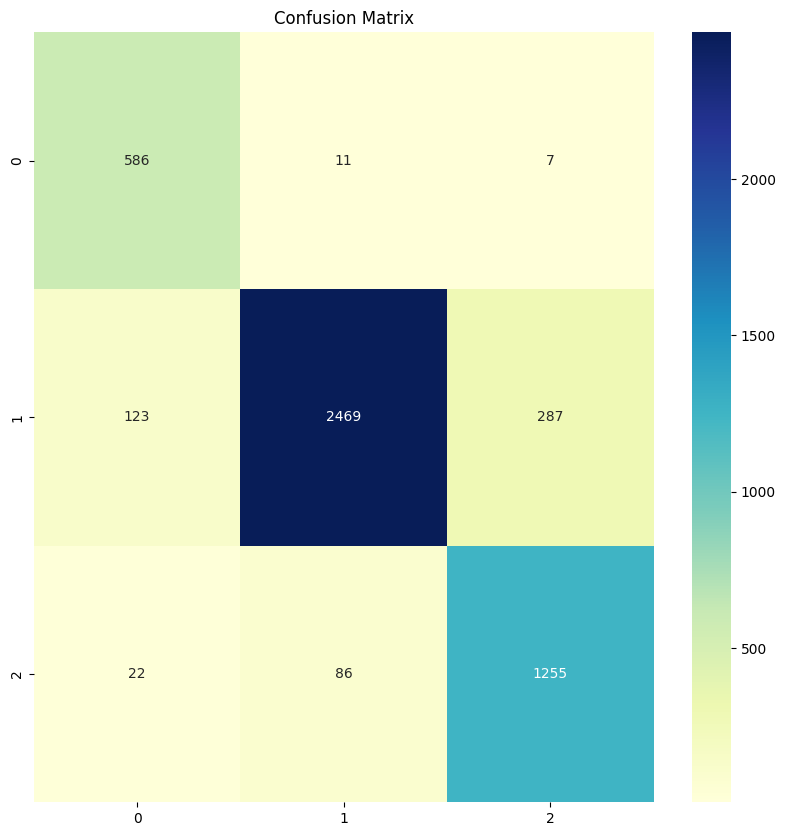

In [15]:
cm = confusion_matrix(y, preds)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.show();